## Citation  
#### Schneider, S., Baevski, A., Collobert, R., & Auli, M. (2019). wav2vec: Unsupervised Pre-Training for Speech Recognition. *arXiv:1904.05862*. https://doi.org/10.48550/arXiv.1904.05862

#### This notebook is a personal explanation and walkthrough of the paper *wav2vec: Unsupervised Pre-Training for Speech Recognition*. All credit for the original research goes to the authors listed above.

**Image Attribution**

#### Unless otherwise noted, all figures in this notebook are either original or sourced from Schneider et al., 2019 — *wav2vec: Unsupervised Pre-Training for Speech Recognition*.


## Overview of Wav2Vec

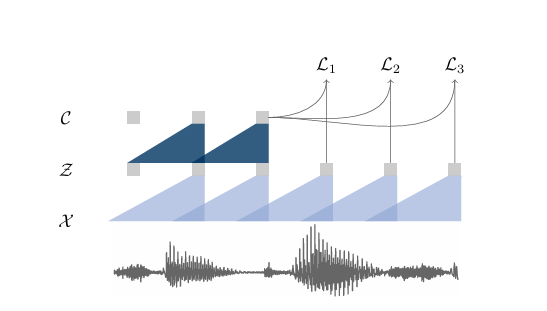

In [2]:
%matplotlib inline
from IPython.display import Image
Image('Images/wav2vec.png')

#### The purpose of Wav2Vec is find meaningful context (C) within from a given audio (X).

#### A few terminologies and concepts before exploring the architecture of Wav2Vec
#### Sampling Rate: It is how many times per second we measure the continuous audio signal to convert it to digital form. For example, 16kHz is 16k samples per second.
#### Nyquist Shannon Sampling Theorem: To capture a frequency accurately, the sample should be at least 2 x that frequency
#### The audio of any input is 16kHz. This is because the range of important information is between 300Hz to 3400Hz for human speech. A 16kHz frequency can accurately capture frequencies upto 8kHz. 8kHz is more than double the 3.4kHz, thus, it provides a safety margin.

# PRE-TRAINING APPROACH

#### The model has two networks:
#### 1) Encoder Network
#### 2) Context Network

## 1) Encoder Network:
#### Mathematically, f:X->Z
#### It is a function where the input audio (X) is used to find the feature representations (Z)
#### Convolutional layers is used to achieve this.
#### The encoder layers have kernel sizes - 10, 8, 4, 4, 4 with strides - 5, 4, 2, 2, 2. 
#### The kernel is like a sliding window that scans across the audio signal.
#### The Stride determines how much the "sliding window" moves each time.

# Mathematical Calculation:
#### Input is 16kHz Raw Audio. This means it is 16k samples per second.
#### For 1 sample, it us 1000s/16k = 0.0625ms
#### After 5 layers: total stride = 5*4*2*2*2 = 160. This means that 160 input samples produces 1 output feature. 
#### Thus, for 160 samples at 16kHz = 160 samples/16000 samples per second = 10ms of audio. This means 1 feature (z_i) for every 10ms.

# 2) Context Network
#### The output of the Encoder Network, that is feature representations (Z) is fed to another function g where g:Z->C. The feature representations is converted to contextualized tensor (c_i).
#### c_i = g(z_i, ... z_i-v) where v is the receptive field. Receptive field is the amount of context or the window the model can see. Here, v = 30ms.
#### Both Receptive field and Kernel are different. Kernel is the moving window whereas receptive field is the fixed context. Assume a photographer wants to take photos with a wide angle lens (30ms field of view) but moving the camera every 10ms. Each photo captures 30ms of scene but a new photo is taken every 10ms.

# Objective

#### To minimuize the contrastive loss for each step K = 1 to k. contrastive means forcing the model to distinguish between real patterns and noise.

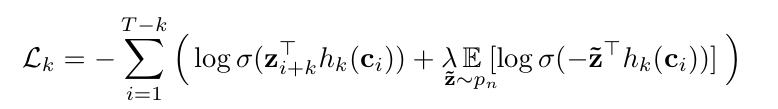

In [3]:
%matplotlib inline
from IPython.display import Image
Image('Images/contrastive_loss.png')

## 1) Summation
#### It iterates over all the valid temporal positions. T = Total sequence length 


## 2) Positive Term

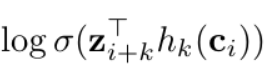

In [5]:
%matplotlib inline
from IPython.display import Image
Image('Images/positive_term.png')

#### σ(x) is the sigmoid function. σ(zi+k^T hk(ci)) is the probability that z_i+k is the true sample. z_i+k is the representation vector from time step i to k.

#### In simpler terms, the positive terms tells how confident are we that THIS is the correct next chunk?

# 3) Negative Term

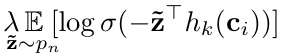

In [7]:
%matplotlib inline
from IPython.display import Image
Image('Images/negative_term.png')

#### z̃ is the fake audio chunck. The sigmoid here signifies the probability the current fake chunk is correct (This is close to 0 as the fake chunk is not the True chunk). λ is the weight factor, it is the number of samples.

#### In simpler terms, the negative term tell how confident are we that these FAKE chunks are NOT the correct next chunk?

## 4) Overall
#### L_k = -(Positive Term + Negative Term). There is a minus sign because we want to minimize the loss so we have to maximise the log probability in the positive term and minimize the log probability in the negative term.

# Decoding

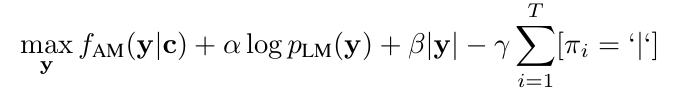

In [1]:
%matplotlib inline
from IPython.display import Image
Image('Images/decoding.png')

#### It consists of 4 parts:
#### 1) Acoustic Model
#### 2) Language Model
#### 3) Word Penalty
#### 4) Silence Penalty

# 1) Acoustic Model

#### It outputs the character probability from the audio. For example, if the word in the audio is 'cat'. The acoustic model will look not consider that the spoken word is cat but rather it will consider each sound/phenome. The model will look at it like: 80% probability that the sound is 'c', 90% sure the sound is 'a' and 75% sure the sound is 't'.

#### In the formula, this is done by f_AM(y|c) where AM = Acoustic Model, y = word sequence given the c = context network.

#### In simpler terms, it is like a sound identifier.

# 2) Language Model

#### It is the probability distribution over sequences of words. In the formula, this is done by p_LM where LM = Language Model, p_LM(y) assigns the probability for the sequence y.

#### For example, assume the dictionary has ['sat', 'talk'] and the word sequence is 'The cat', then the next word may the probability distribution as: Sat = 0.95 (95%), Talk = 0.05 (5%). Hence, the next word will be taken as 'sat', then the process repeats until the terminal state is achieved.

# 3) Word Penalty

#### This is to control the length of the answer. β is the hyper-parameter which controls this. 
#### If β is more than 0, then it means the word length can be more.
#### If β is less than 0, then the word length should be smaller.
#### If β = 0 , then the word length has no preference.

#### This is achieved using the β|y| where β = the word penalty and y = word sequence.

# 4) Silence Penalty

#### The model needs to insert some character to represent that there is a silence in the audio.
#### The hyperparameter γ controls the amount of '|' characters which can be placed in the sentence.
#### Large γ means Strong penalty, fewer silences allowed.
#### Small γ means Weak penalty, more silences allowed.

# How all these 4 terms can be combined?

#### The Acoustic model is taken, it gives the charater output.
#### The language model is used to give the most probable sequence. It is added to the equation because the higher the probability, the higher should be the weightage of the output.
#### The Word penalty term is used to reward or penalise based on the value of the β. So the addition denotes that the term will contribute positively if β is positive, otherwise, the word penalty term will be negative which when added will result negatively to the overall result.
#### The Silence penalty is subtracted to penalize when there is more silence.

# Conclusion

#### Wav2Vec learns useful speech representations directly from raw audio waveforms in a self-supervised way. It uses a convolutional feature encoder to transform the audio into latent representations. Then, a context network (based on CNNs) builds contextualized representations by looking at a wider temporal window. The model is trained with a contrastive loss: it tries to correctly identify the true future audio representation among a set of distractors. Once pretrained, these representations can be fed into downstream acoustic models and improve speech recognition performance, even with limited labeled data.